### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier



import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SMOTEN,SVMSMOTE,KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler,NearMiss
from imblearn.combine import SMOTEENN,SMOTETomek

from collections import Counter

from sklearn.cluster import DBSCAN



In [2]:
random_state = 23873

### Data Import

In [3]:
dt = pd.read_excel(r'CA_BC.xlsx').T
dt.columns = dt.iloc[0]
dt = dt.iloc[1:]
dt['Label'] = dt.Label.map({'E':1,'A':0})

In [4]:
dt.shape

(128, 20532)

In [5]:
dt.drop_duplicates(keep='first',inplace=True)
for x in dt.select_dtypes(include=['object']).columns:
    dt[x] = dt[x].astype('float64')
dt.columns = [str(x) for x in dt.columns]
dt = dt.select_dtypes(include=['float64','int64'])

In [21]:
# Columns to not rename
excluded = dt.columns[~dt.columns.duplicated(keep=False)]

# An incrementer
import itertools
inc = itertools.count().__next__

# A renamer
def ren(name):
    return f"{name}{inc()}" if name not in excluded else name

# Use inside rename()
dt.rename(columns=ren,inplace=True)

In [7]:
dt.shape

(128, 20532)

In [8]:
# Counter(dt.columns).most_common()

### Test and Train Split

In [23]:
features = dt.copy()
target = features.pop('Label')

# ros = RandomUnderSampler(sampling_strategy = 0.1,random_state = random_state)
# features, target = ros.fit_resample(features, target)
# print(sorted(Counter(target).items()))


x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.1)

### Scorers

#### tss

In [10]:
def tss(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    tss = (tp/p) - (fp/n)
    return tss

In [11]:
# tss([0, 1, 0, 1], [1, 1, 1, 0])
tss_scorer = make_scorer(tss,greater_is_better=True)

#### hss2

In [12]:
def hss2(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    hss2 = (2 * ((tp*tn) - (fn*fp))) / (p*(fn+tn) + n*(tp+fp))
    return hss2

In [13]:
# hss2([0, 1, 0, 1], [1, 1, 1, 0])
hss2_scorer = make_scorer(hss2,greater_is_better=True)

### Baseline Modelling

In [14]:
# Decision Tree
# Logistic Regression
# KNeighbours
# Support Vector Machine
# Naive Bayes
# AdaBoost
# RandomForest
# ExtraTrees
# GradientBoosting
# Linear Discriminant Analysis
# XGBoost


In [15]:
def baseline_modelling(x_train, y_train,scoring):
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    means = []
    std = []

    classifiers = [LogisticRegression(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
                  SVC(random_state=random_state),NearestNeighbors(),GaussianNB(),AdaBoostClassifier(random_state=random_state),
                    RandomForestClassifier(n_estimators=20,random_state=random_state),XGBClassifier()
                  ]

    for classifier in classifiers:
            scores = cross_val_score(classifier, x_train, y_train, scoring=scoring, cv=cv)
            means.append(scores.mean())
            std.append(scores.std())

    cv_res = pd.DataFrame(data={'Algorithms':['LogisticRegression','DecisionTree','SVM','KNN','Naive Bayes','AdaBoost',
                                              'RandomForest','XGBoost'], 'Mean Score':means, 'std':std})

    sns.barplot(x = 'Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2").set(title='Cross Validation Scores')
    plt.show()

    return cv_res

In [16]:
def modelling_mulitple(x_train, y_train):

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    f1_means,f1_std,tss_mean,tss_std,hss2_mean,hss2_std = [],[],[],[],[],[]

    classifiers = [LogisticRegression(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
                  SVC(random_state=random_state),GaussianNB(),AdaBoostClassifier(random_state=random_state),
                    RandomForestClassifier(n_estimators=20,random_state=random_state),XGBClassifier()
                  ]

    scoring = {'f1_macro': 'f1_macro',
               'tss': tss_scorer,
               'hss2': hss2_scorer}

    for classifier in classifiers:
        print(classifier)
        scores = cross_validate(classifier, x_train, y_train, scoring=scoring, cv=cv)
        f1_means.append(scores['test_f1_macro'].mean())
        f1_std.append(scores['test_f1_macro'].std())
        tss_mean.append(scores['test_tss'].mean())
        tss_std.append(scores['test_tss'].std())
        hss2_mean.append(scores['test_hss2'].mean())
        hss2_std.append(scores['test_hss2'].std())

    cv_res = pd.DataFrame(data={'Algorithms':['LogisticRegression','DecisionTree','SVM','Naive Bayes','AdaBoost',
                                              'RandomForest','XGBoost'], 'F1 Mean Score':f1_means, 'F1 std':f1_std,
                               'TSS Mean Score':tss_mean, 'TSS std':tss_std, 'HSS2 Mean Score':hss2_mean, 'HSS2 std':hss2_std
                               })

    plt.rcParams["figure.figsize"] = [20.00, 6.00]
    plt.rcParams["figure.autolayout"] = True
    f, axes = plt.subplots(1, 3)

    sns.barplot(x = 'F1 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[0]).set(title='Cross Validation Scores')
    sns.barplot(x = 'TSS Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[1]).set(title='Cross Validation Scores')
    sns.barplot(x = 'HSS2 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[2]).set(title='Cross Validation Scores')

    plt.show()

    return cv_res

LogisticRegression(random_state=23873)
DecisionTreeClassifier(random_state=23873)
SVC(random_state=23873)
GaussianNB()
AdaBoostClassifier(random_state=23873)
RandomForestClassifier(n_estimators=20, random_state=23873)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


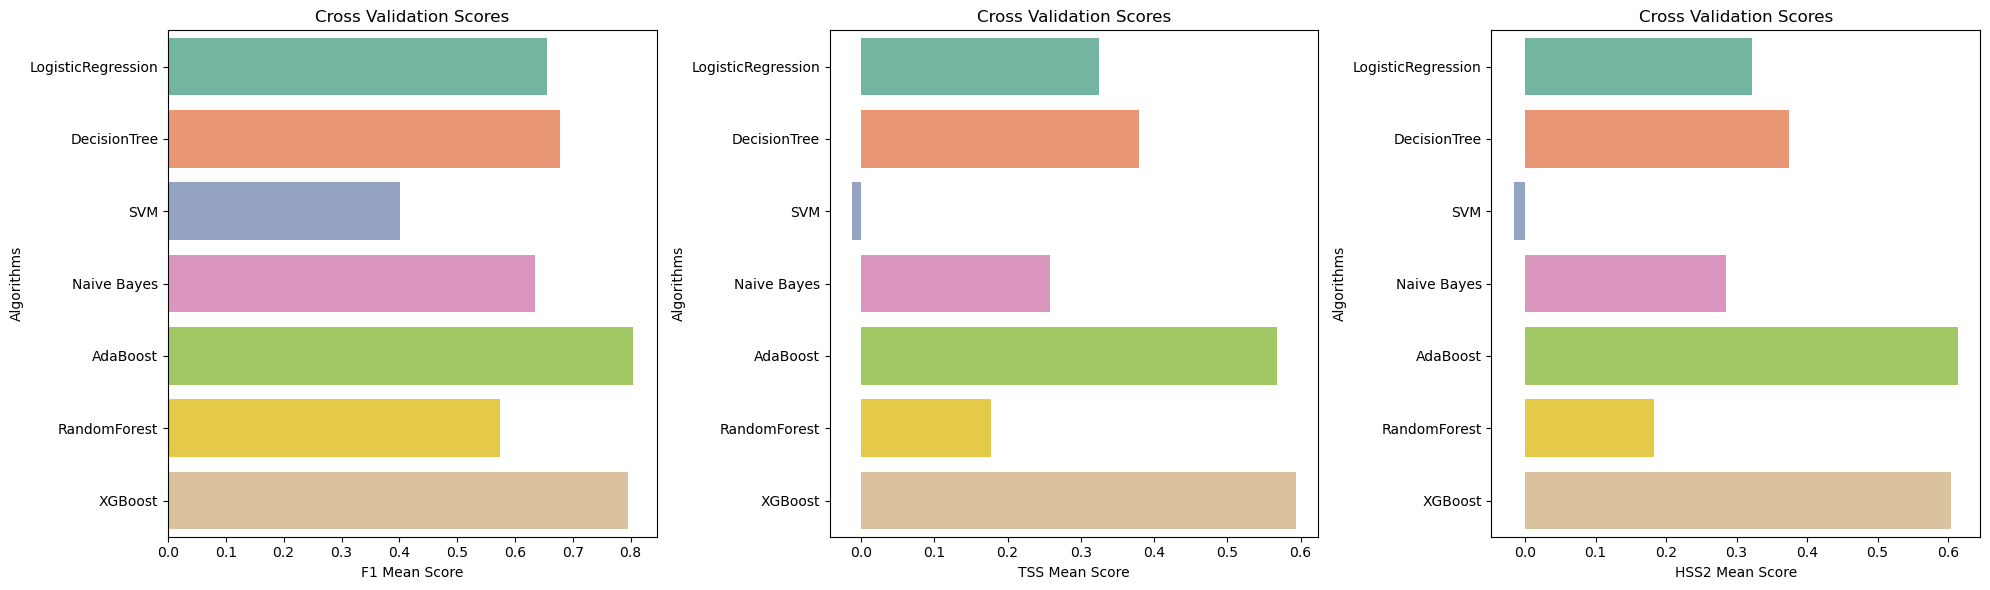

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.656004,0.049039,0.324524,0.080568,0.321836,0.096289
1,DecisionTree,0.677759,0.142092,0.378690,0.265511,0.374612,0.260993
2,SVM,0.400945,0.007603,-0.012500,0.025000,-0.016471,0.032941
3,Naive Bayes,0.635062,0.111001,0.258095,0.195269,0.284813,0.218804
4,AdaBoost,0.804747,0.068769,0.567857,0.121455,0.613693,0.138712
5,RandomForest,0.573647,0.086442,0.176905,0.162018,0.182062,0.158523
6,XGBoost,0.796126,0.126579,0.593810,0.233374,0.603779,0.236465


In [24]:
modelling_mulitple(x_train, y_train)

In [25]:
# baseline_modelling(x_train, y_train,'f1_macro')
# baseline_modelling(x_train, y_train,tss_scorer)
# baseline_modelling(x_train, y_train,hss2_scorer)

### Data Normalization

#### Min Max Scaler

In [26]:
x_train_MinMax = MinMaxScaler().fit_transform(x_train)

LogisticRegression(random_state=23873)
DecisionTreeClassifier(random_state=23873)
SVC(random_state=23873)
GaussianNB()
AdaBoostClassifier(random_state=23873)
RandomForestClassifier(n_estimators=20, random_state=23873)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


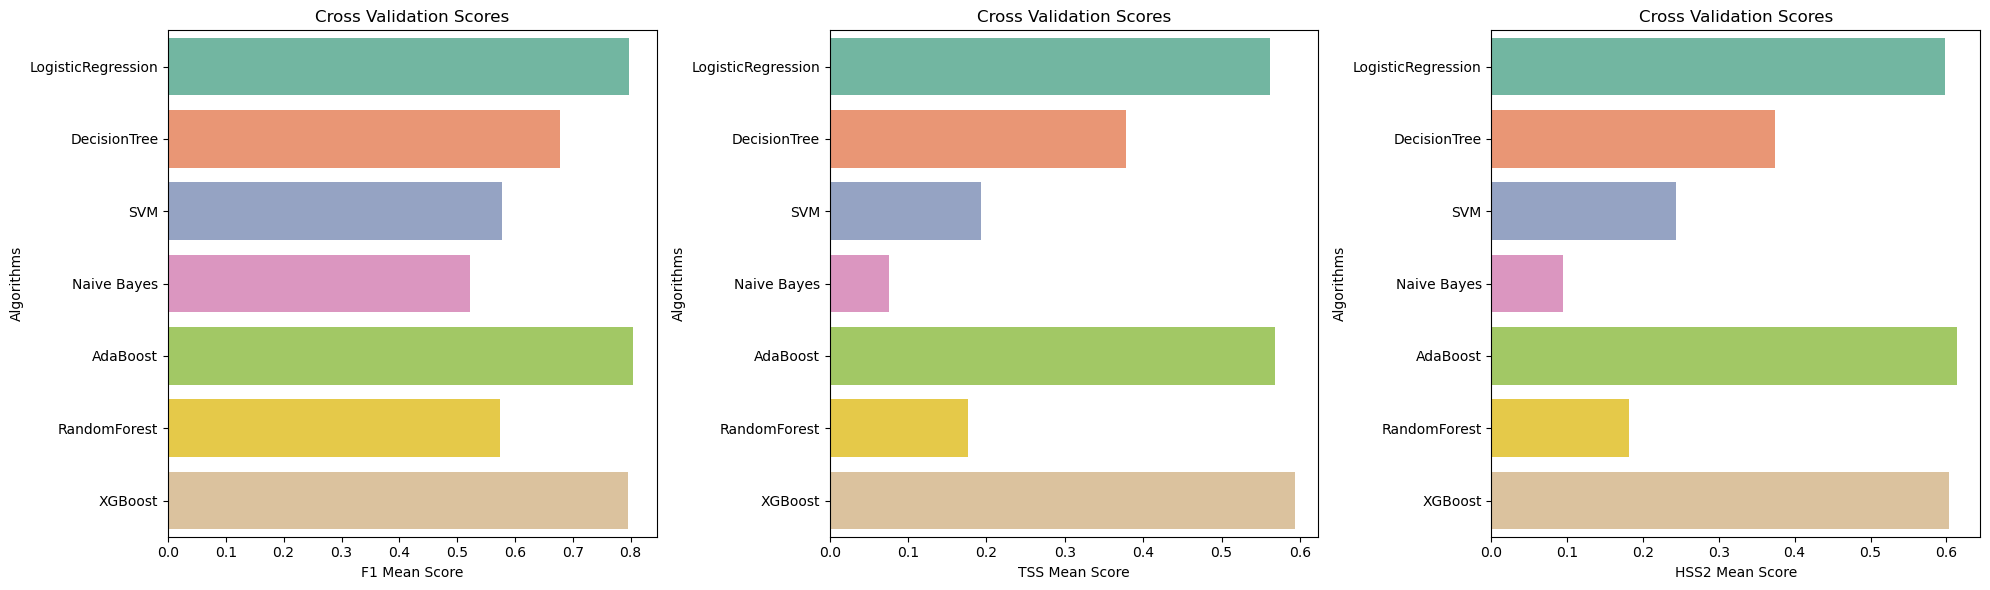

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.796356,0.031035,0.561667,0.051473,0.598842,0.061119
1,DecisionTree,0.677759,0.142092,0.378690,0.265511,0.374612,0.260993
2,SVM,0.577679,0.063769,0.192857,0.076097,0.243491,0.093815
3,Naive Bayes,0.521767,0.065296,0.076190,0.115337,0.093835,0.132135
4,AdaBoost,0.804747,0.068769,0.567857,0.121455,0.613693,0.138712
5,RandomForest,0.573647,0.086442,0.176905,0.162018,0.182062,0.158523
6,XGBoost,0.796126,0.126579,0.593810,0.233374,0.603779,0.236465


In [27]:
modelling_mulitple(x_train_MinMax, y_train)

#### Standard Scaler

In [28]:
x_train_Standard = StandardScaler().fit_transform(x_train)

LogisticRegression(random_state=23873)
DecisionTreeClassifier(random_state=23873)
SVC(random_state=23873)
GaussianNB()
AdaBoostClassifier(random_state=23873)
RandomForestClassifier(n_estimators=20, random_state=23873)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


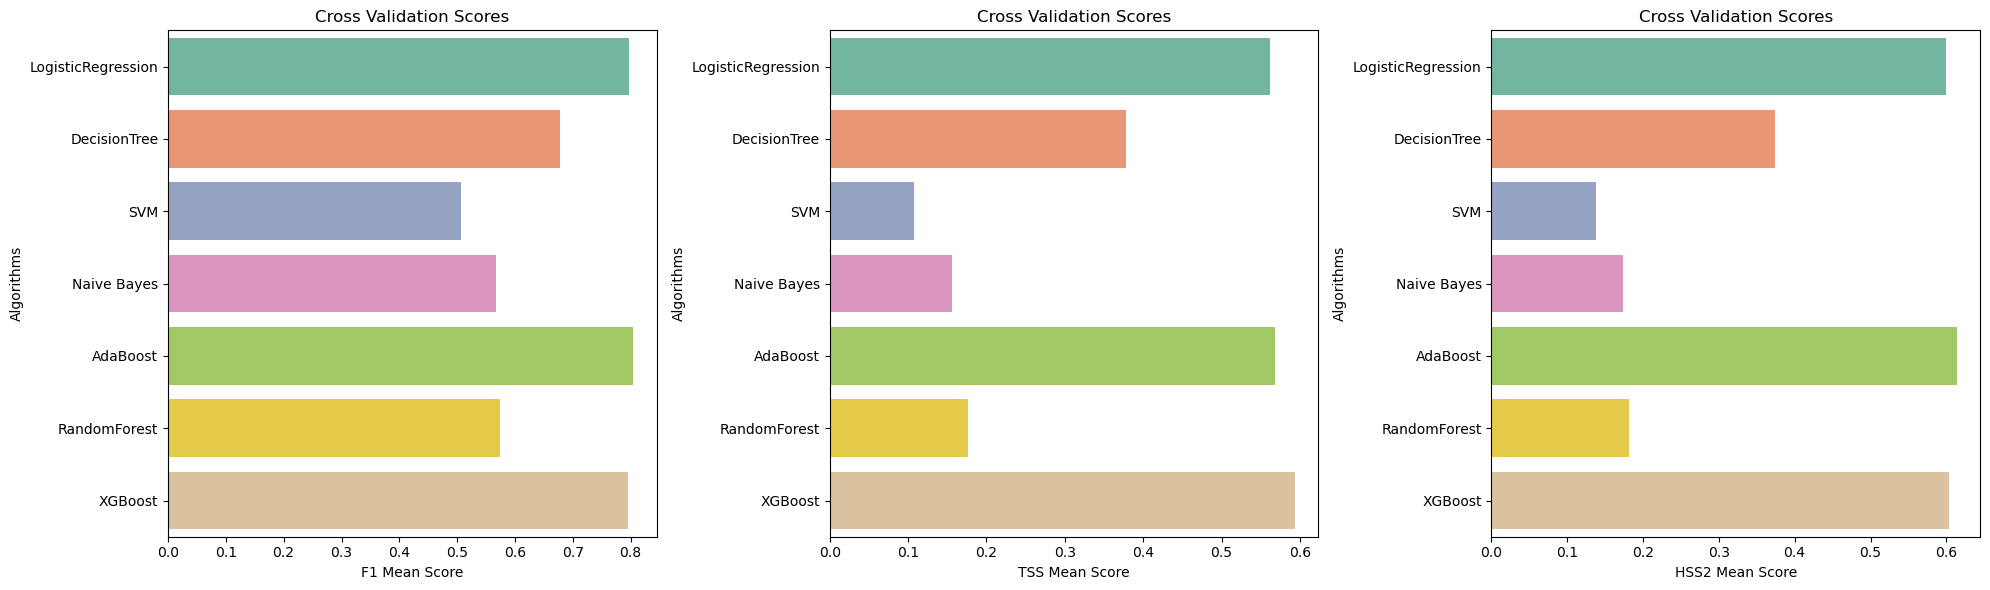

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.796745,0.045425,0.561667,0.077349,0.599014,0.089825
1,DecisionTree,0.677759,0.142092,0.378690,0.265511,0.374612,0.260993
2,SVM,0.507079,0.050181,0.107143,0.054163,0.138121,0.070453
3,Naive Bayes,0.567655,0.060571,0.155595,0.086511,0.173989,0.090162
4,AdaBoost,0.804747,0.068769,0.567857,0.121455,0.613693,0.138712
5,RandomForest,0.573647,0.086442,0.176905,0.162018,0.182062,0.158523
6,XGBoost,0.796126,0.126579,0.593810,0.233374,0.603779,0.236465


In [29]:
modelling_mulitple(x_train_Standard, y_train)

### Data Re- Sampling

#### Over Sampling

In [30]:
# Random Over Sampling
# Random Undersampling
# SMOTE
# SMOTE and Undersmapling
# Random Over Sampling and Undersmapling
# BorderLine
# ADASYN
# SVMSMOTE

#https://imbalanced-learn.org/stable/over_sampling.html

###### Random Over Sampling

In [31]:
# ros = RandomOverSampler(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### SMOTE

In [32]:
# ros = SMOTE(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### ADASYN

In [33]:
# ros = ADASYN(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### BorderlineSMOTE

In [34]:
# ros = BorderlineSMOTE(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### SVMSMOTE

In [35]:
# ros = SVMSMOTE(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### SMOTEN

In [36]:
# ros = SMOTEN(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### KMeansSMOTE

In [37]:
# ros = KMeansSMOTE(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(x_train_samp, y_train_samp)

#### Undersampling

###### ClusterCentroids

In [38]:
# ros = ClusterCentroids(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### RandomUnderSampler

In [39]:
# ros = RandomUnderSampler(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### NearMiss

In [40]:
# ros = NearMiss(version=1)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

#### Combined Over & Undersampling

###### SMOTETomek

In [41]:
# ros = SMOTETomek(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

 ###### SMOTEENN

In [42]:
# ros = SMOTEENN(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

#### Feature Selection

###### Feed Forward (Support Vector Machine) (F1 Score)


In [43]:
y_train.value_counts()

1    78
0    37
Name: Label, dtype: int64

In [44]:
def classifier(x_train, y_train,scoring):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    classifiers = LogisticRegression()
    scores = cross_val_score(classifiers, MinMaxScaler().fit_transform(x_train), y_train, scoring=scoring, cv=cv)
    
    return scores.mean()

In [45]:
def feed_forward(unprocessed_cols,current_bestcols,scoring):
    
    results = [classifier(StandardScaler().fit_transform(x_train[current_bestcols + [x]]), y_train,scoring) for x in unprocessed_cols]
    current_bestcols = current_bestcols + [unprocessed_cols[results.index(max(results))]]
    bestcols.append((max(results), current_bestcols))
    unprocessed_cols.pop(results.index(max(results)))
    if len(unprocessed_cols) > 0:
        print(f"{len(unprocessed_cols)} columns left to process")
        feed_forward(unprocessed_cols,current_bestcols,scoring)
    else:
        return bestcols

In [46]:
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
bestcols = []
cols = x_train.columns.tolist()
feed_forward(cols,bestcols,scoring='f1_macro')
sns.lineplot(x=[len(x[1]) for x in bestcols], y=[x[0] for x in bestcols], palette='Set2')
plt.xlabel('Number of Columns')
plt.ylabel('Scores')
plt.show()

20530 columns left to process
20529 columns left to process
20528 columns left to process
20527 columns left to process
20526 columns left to process
20525 columns left to process
20524 columns left to process
20523 columns left to process
20522 columns left to process
20521 columns left to process
20520 columns left to process
20519 columns left to process
20518 columns left to process
20517 columns left to process
20516 columns left to process
20515 columns left to process
20514 columns left to process
20513 columns left to process
20512 columns left to process
20511 columns left to process
20510 columns left to process
20509 columns left to process
20508 columns left to process
20507 columns left to process
20506 columns left to process
20505 columns left to process
20504 columns left to process
20503 columns left to process
20502 columns left to process
20501 columns left to process
20500 columns left to process
20499 columns left to process
20498 columns left to process
20497 colu

In [ ]:
bestcols

In [ ]:
# bestcols = []
# cols = x_train.columns.tolist()
# feed_forward(cols,bestcols,scoring=tss_scorer)
# sns.lineplot(x=[len(x[1]) for x in bestcols], y=[x[0] for x in bestcols], palette='Set2')
# plt.xlabel('Number of Columns')
# plt.ylabel('Scores')
# plt.show()

In [164]:
# bestcols = []
# cols = x_train.columns.tolist()
# feed_forward(cols,bestcols,scoring=hss2_scorer)
# sns.lineplot(x=[len(x[1]) for x in bestcols], y=[x[0] for x in bestcols], palette='Set2')
# plt.xlabel('Number of Columns')
# plt.ylabel('Scores')
# plt.show()

#### Noise Reduction

###### DBSCAN

In [39]:
# # Use random Undersampling to stabilize the data
# ros = RandomUnderSampler(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(MinMaxScaler().fit_transform(x_train_samp), y_train_samp)

In [50]:
# Sampled data
data = StandardScaler().fit_transform(x_train_samp[bestcols[5][1]])

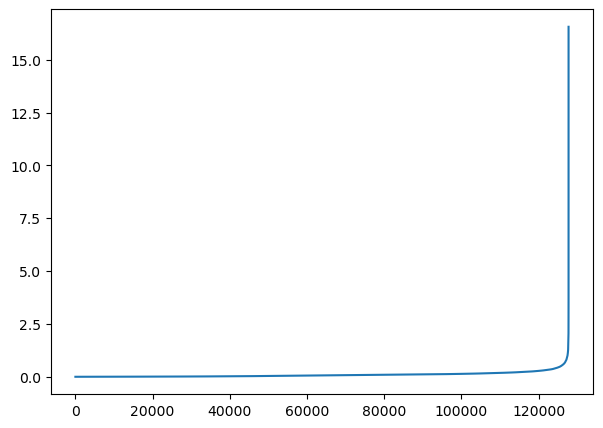

In [51]:
# Optimal Eps
#https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = [7.00, 5.00]

plt.plot(distances)
plt.show()

In [52]:
db = DBSCAN(eps = 0.25, min_samples = 5).fit(data) 
labels = db.labels_

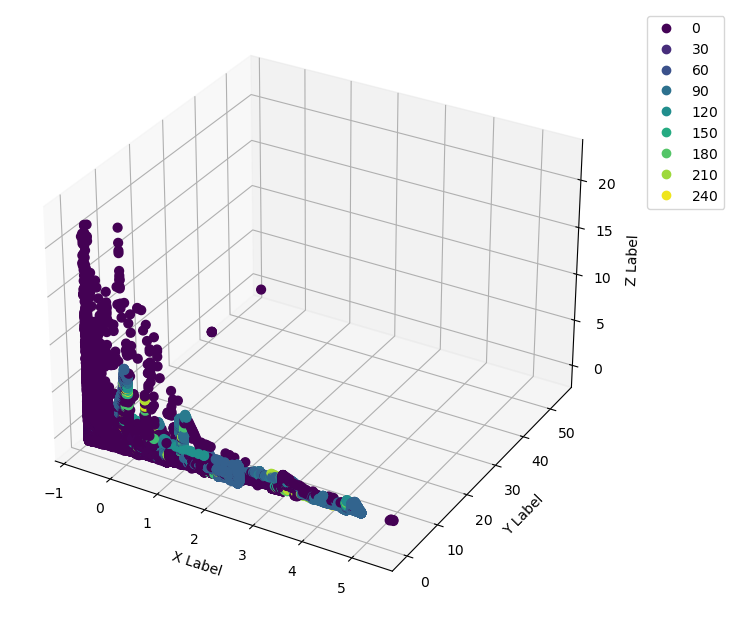

In [53]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter([x[0] for x in data], [x[1] for x in data], [x[2] for x in data], s=40, c=labels, marker='o', alpha=1)
# sc = ax.scatter(data[data.columns[0]], data[data.columns[1]], data[data.columns[2]], s=40, c=labels, marker='o', alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.show()

In [54]:
idxs = [idx for idx, value in enumerate(labels.tolist()) if value == -1]
to_check = x_train_samp.index.tolist()
noise = [value for idx,value in enumerate(to_check) if idx in idxs]

In [55]:
# modelling_mulitple(x_train_samp[x_train_samp.index.isin(noise)], y_train_samp[y_train_samp.index.isin(noise)])

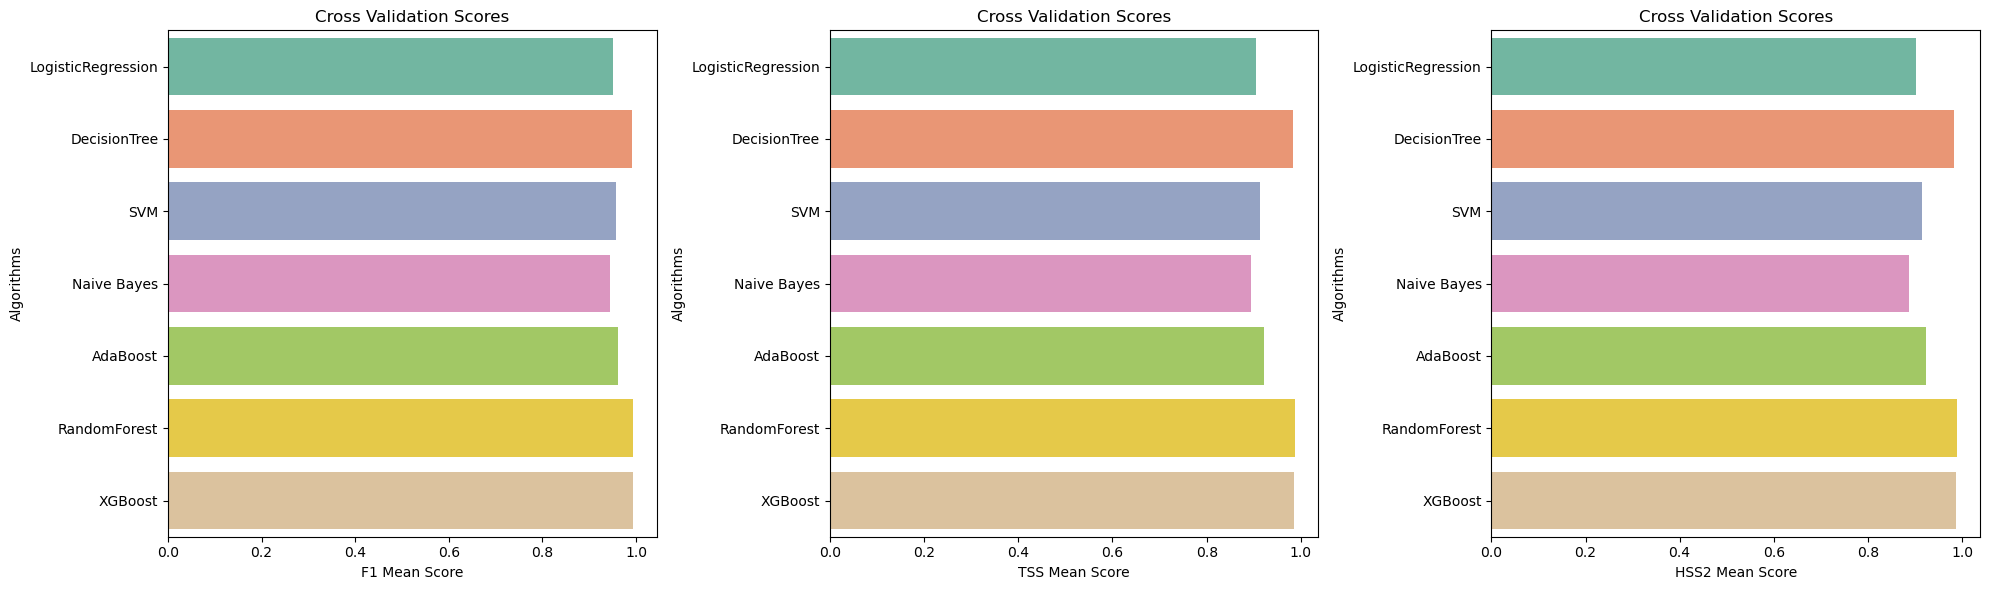

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.950931,0.001108,0.904780,0.002254,0.901880,0.002216
1,DecisionTree,0.991803,0.000613,0.983114,0.001278,0.983607,0.001226
2,SVM,0.957381,0.001069,0.914128,0.002158,0.914764,0.002139
3,Naive Bayes,0.944092,0.001522,0.893529,0.002994,0.888251,0.003039
4,AdaBoost,0.961881,0.001180,0.920805,0.002458,0.923776,0.002360
5,RandomForest,0.994325,0.000300,0.987524,0.000648,0.988650,0.000601
6,XGBoost,0.993271,0.000333,0.985211,0.000716,0.986543,0.000666


In [56]:
# 0.917269	0.004286	0.834551	0.008577	0.834553	0.008574
modelling_mulitple(MinMaxScaler().fit_transform(x_train_samp[~x_train_samp.index.isin(noise)][bestcols[5][1]]), y_train_samp[~y_train_samp.index.isin(noise)])